In [2]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import h5py
import pandas as pd

#this sets the size of the plot to something useful
plt.rcParams["figure.figsize"] = (20,15)

## Lab#4 Working with 'real' data

### Setup

In [3]:
hf = h5py.File('gammaray_lab4.h5', 'r')

In [4]:
hf.keys()

<KeysViewHDF5 ['data']>

In [5]:
data = np.array(hf.get('data'))

In [6]:
data.shape

(4, 25920001)

In [7]:
hf.close()

### Problem 1

Here, we are looking at data from a gamma-ray satellite that is orbiting in the low Earth orbit. The satellite takes a reading of the number of particles detected every 100ms and is in a 90 minute orbit. The data that we are working with comes from this satellite alongside some metadata like the time of measurement, the Solar phase, Earth's longitude, and the number of particles detected. We will be working with around 25 million of these observations.

In [8]:
data = data.T
data.shape

(25920001, 4)

In [9]:
df = pd.DataFrame(data, columns=['Time (gps seconds)', 'Solar phase (deg)', 'Earth longitude (deg)', 'Num. of observations'])
df

,Time (gps seconds),Solar phase (deg),Earth longitude (deg),Num. of observations
0,940680016.0,315.000000,45.000000,10.0
1,940680016.1,315.007112,45.006667,8.0
2,940680016.2,315.014225,45.013333,7.0
3,940680016.3,315.021337,45.020000,11.0
4,940680016.4,315.028449,45.026667,8.0
...,...,...,...,...
25919996,943272015.6,345.304884,44.973333,5.0
25919997,943272015.7,345.311996,44.980000,9.0
25919998,943272015.8,345.319109,44.986667,8.0
25919999,943272015.9,345.326221,44.993333,11.0


Text(0, 0.5, 'Number of observations')

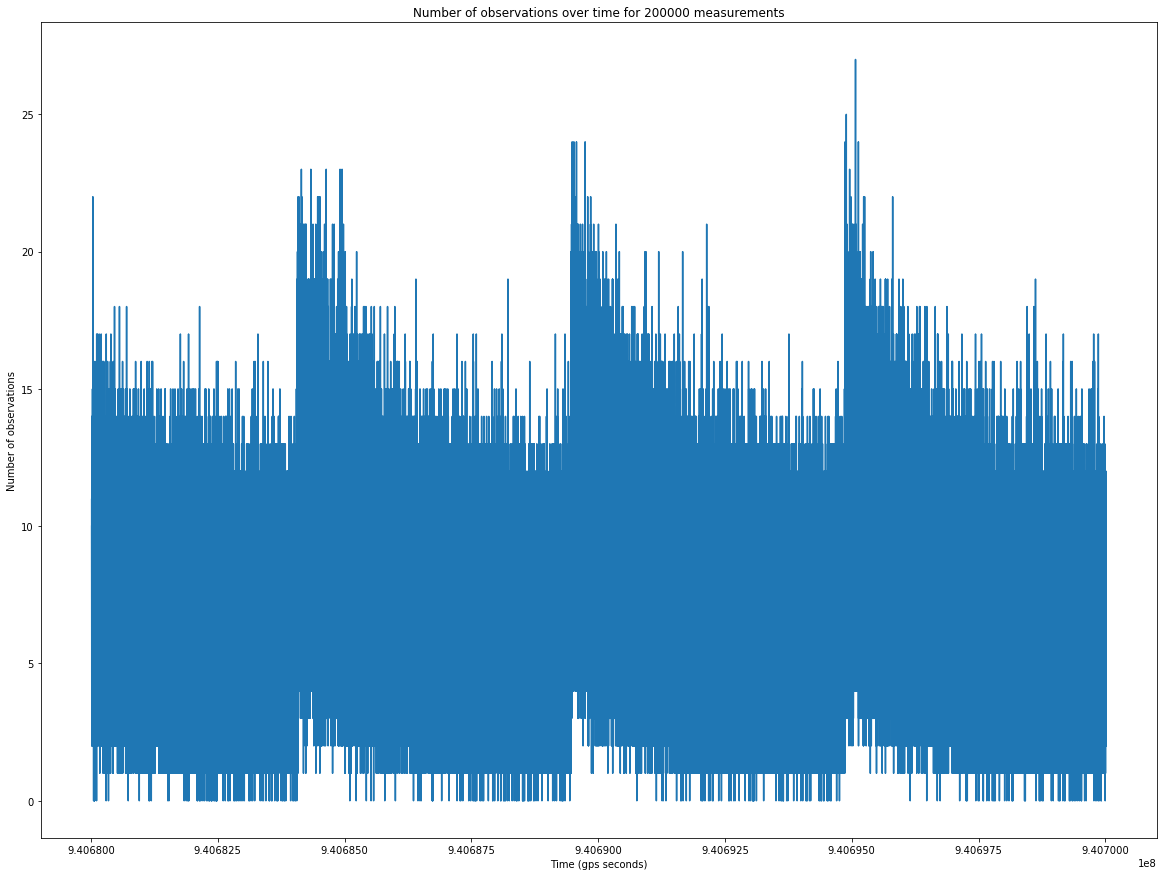

In [11]:
num_points = 200000
plt.plot(df['Time (gps seconds)'][0:num_points], df['Num. of observations'][0:num_points])
plt.title('Number of observations over time for ' + str(num_points) + ' measurements')
plt.xlabel('Time (gps seconds)')
plt.ylabel('Number of observations')

By looking at plot, we can see that the data seems to have periodic jumps in the number of observations and the overall pattern seems to be quite stable. We can try and get a better picture of the background distribution by instead creating a histogram.

Text(0.5, 1.0, 'Probability distribution of raw data over 200,000 observations')

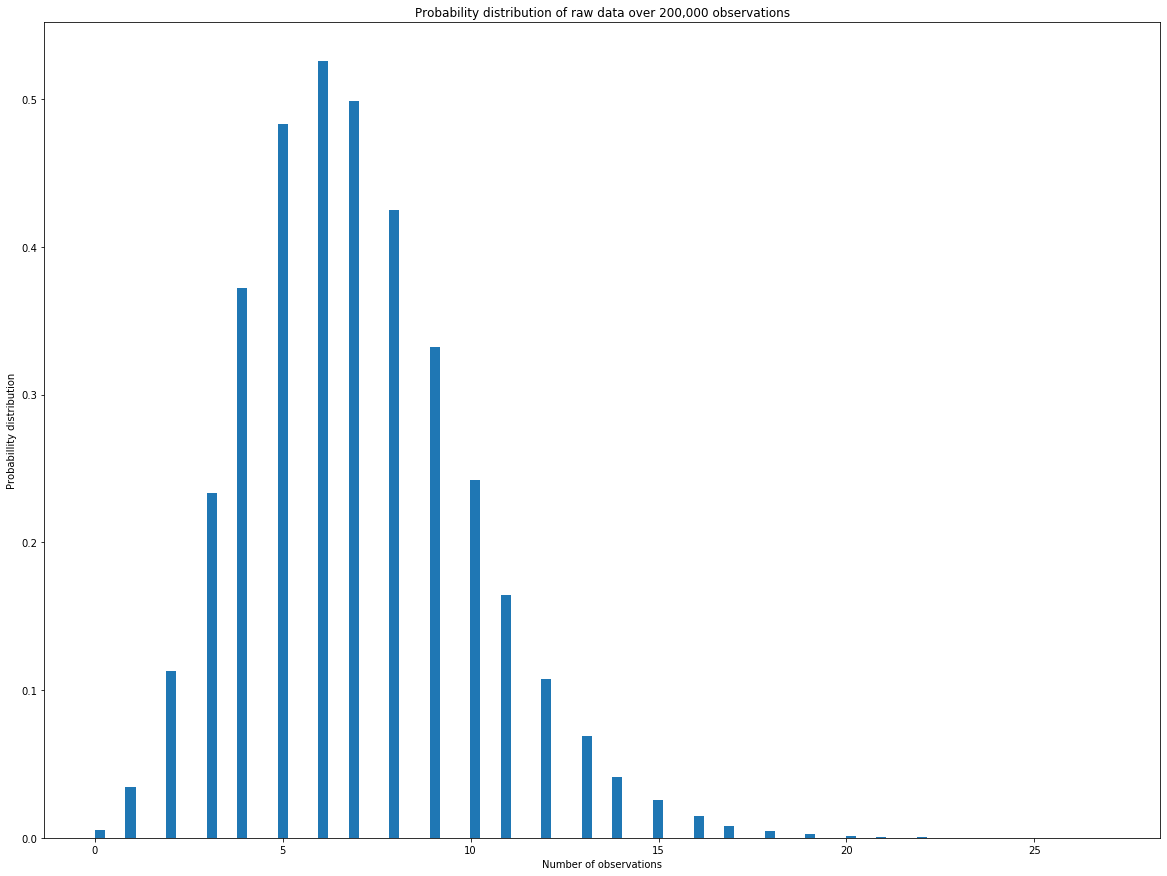

In [12]:
_ = plt.hist(df['Num. of observations'][0:num_points], density = True, bins=100)
plt.xlabel('Number of observations')
plt.ylabel('Probabillity distribution')
plt.title('Probability distribution of raw data over 200,000 observations')

By looking at the probability distribution of our data, it seems to resemble a Poisson distribution based on the fact that it is discrete and the long tail on the right. The mean seems to be around 6 observations. In order to further check if the data represents a Poisson distribution, we can plot it on a log scale along side a Poisson distribution.

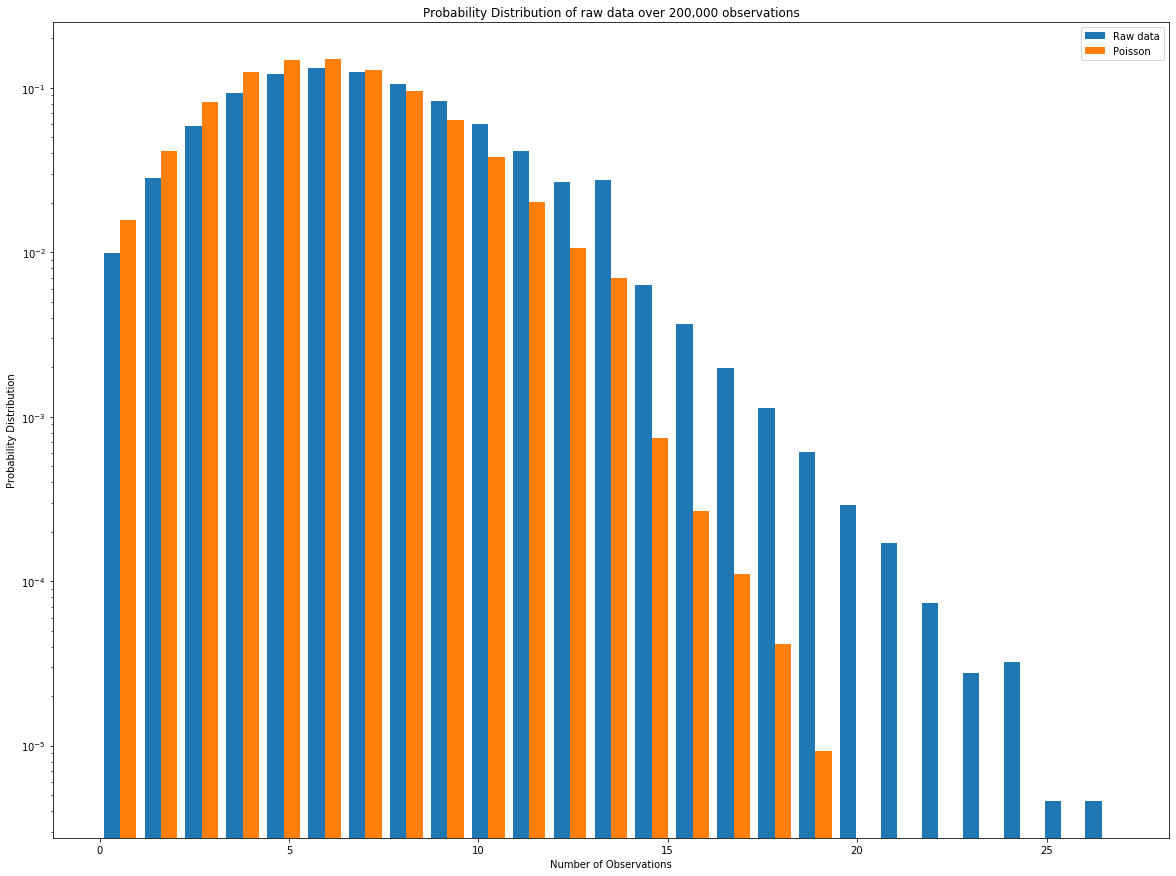

In [13]:
dist = stats.poisson(6)
vals = dist.rvs(num_points)

_ = plt.hist([df['Num. of observations'][0:num_points], vals], density = True, bins=25)
plt.title('Probability Distribution of raw data over 200,000 observations')
plt.xlabel('Number of Observations')
plt.ylabel('Probability Distribution')
plt.legend(['Raw data', 'Poisson'])
plt.yscale('log')

Looking at this comparison, we can tell that the distribution is not Poisson after all. The tail extends a lot more than it should and the probabilities for observations closer to the mean are not as high as they should be. This could be attributed to the spikes that we saw earlier; however, this also means that our data has some signal contamination that we need to tackle before we can find the exact background distribution.

In order to further observe our data, we can also study how the metadata changes over time. This could help us find any inconsistencies with our data.

/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


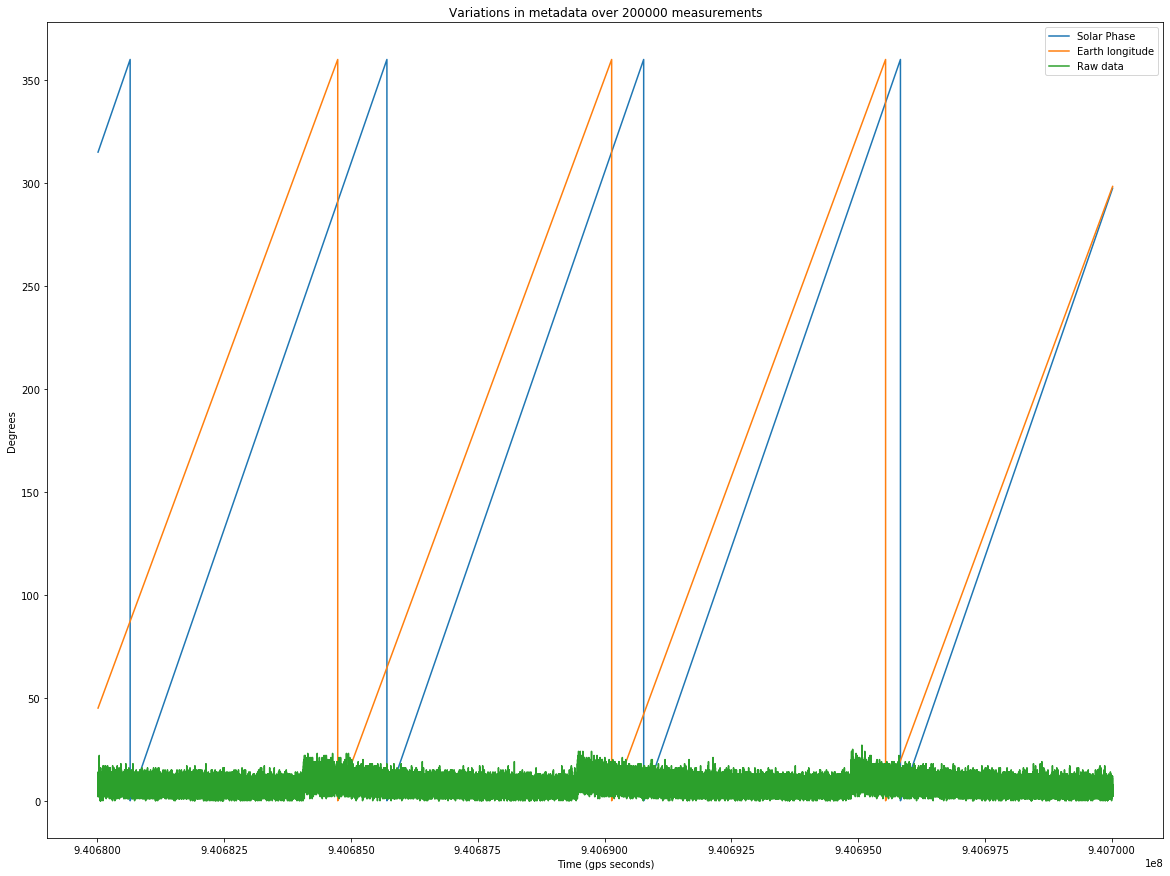

In [14]:
plt.plot(df['Time (gps seconds)'][0:num_points], df['Solar phase (deg)'][0:num_points], label = 'Solar Phase')
plt.plot(df['Time (gps seconds)'][0:num_points], df['Earth longitude (deg)'][0:num_points], label = 'Earth longitude')
plt.plot(df['Time (gps seconds)'][0:num_points], df['Num. of observations'][0:num_points], label = 'Raw data')
plt.title('Variations in metadata over ' + str(num_points) + ' measurements')
plt.xlabel('Time (gps seconds)')
plt.ylabel('Degrees')
plt.legend()

We can see that both the Solar phase and the Earth longitude follow a similar pattern to what we saw earlier with the number of observations. In comparison to our data, we can be certain that the solar phase is not responsible for the spikes, but the longitude of the satellite relative to the Earth is probably what is responsible. To confirm this observation, we look at the number of observations over the same period and from there we can see that the spikes between the observations are similar to the spikes within the longitude and they start to occur between 300 and 350 degrees relative to the Earth. Furthermore, the period of the spikes is also consistent with the 90 minute orbit that we know of.

Our earlier model for the background did not make sense; however, now that we have identified the cause of our contamination we can create a model that depends on the readings over time outside the region. These observations should be relatively flat and can be generalized into a distrbution

Now we know that there is some brighter than normal area between 300-350 degrees longitude that is responsible for the spikes in our data and this region is probably what is responsible for the contamination of our data. Now our next step would be to discard the data found within this region and try and see if the background distribution can be identified.

In [15]:
new_data = df['Earth longitude (deg)'] < 300
new_raw = df['Num. of observations'][new_data]
print('The new data is centered around ' + str(np.mean(new_raw)))

The new data is centered around 6.69923283799848


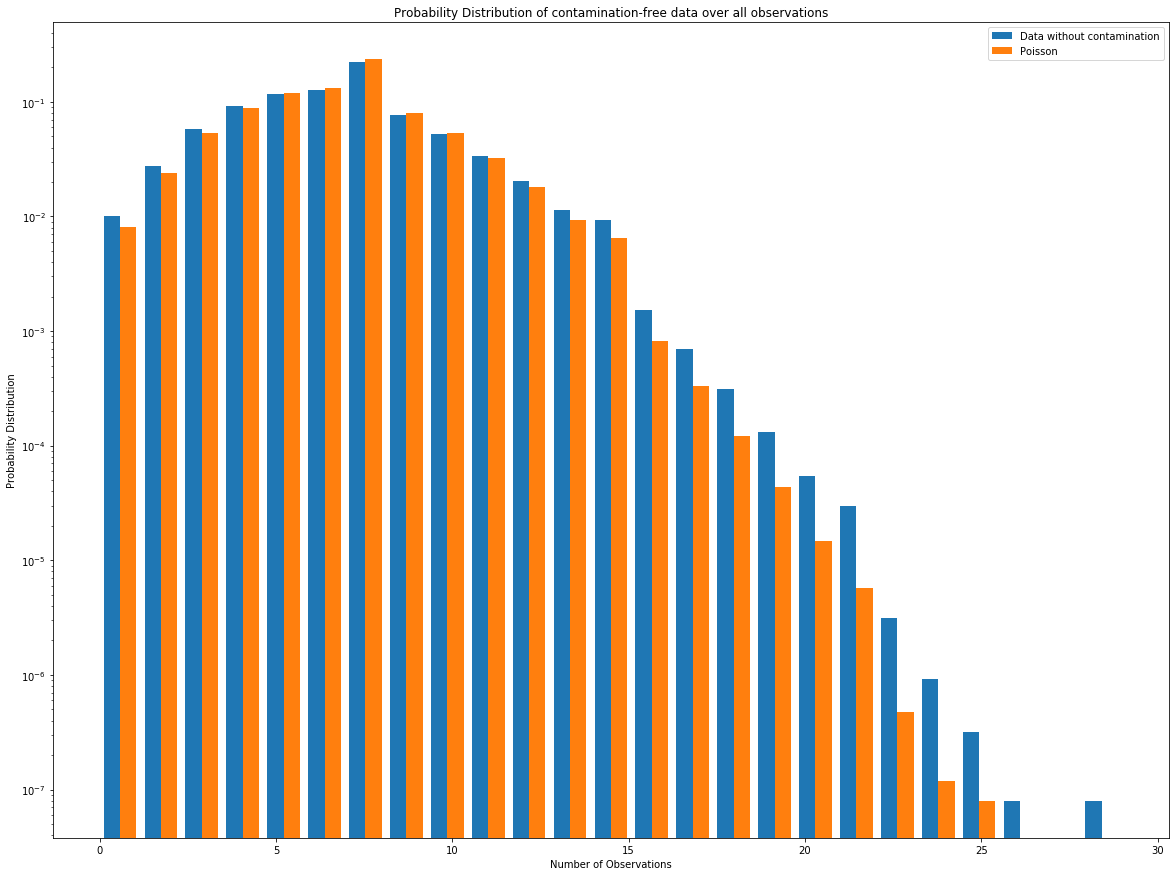

In [19]:
dist_2 = stats.poisson(np.mean(new_raw))
vals_2 = dist_2.rvs(len(new_raw))

_ = plt.hist([new_raw, vals_2], density = True, bins=25)
plt.title('Probability Distribution of contamination-free data over all observations')
plt.xlabel('Number of Observations')
plt.ylabel('Probability Distribution')
plt.legend(['Data without contamination', 'Poisson'])
plt.yscale('log')

Now if look at the distribution of our data without the contamination, we can see that it is in fact a poisson distribution that is centered around 6.7. 


We can now find the 5-sigma threshold for this model.

In [36]:
threshold  = dist_2.ppf(stats.norm.cdf(5))
print('The 5-sigma threshold is ' + str(threshold) + ' observations.')

The 5-sigma threshold is 23.0 observations.


Given that our model uses all the times when the satellite is not in the region, we can look at the time when it is in the region.

In [28]:
cont_data = (df['Earth longitude (deg)'] > 300) & (df['Earth longitude (deg)'] < 360)
cont_raw = df['Num. of observations'][cont_data]
print('The contaminated data is centered around ' + str(np.mean(cont_raw)))

The contaminated data is centered around 9.088033855613586


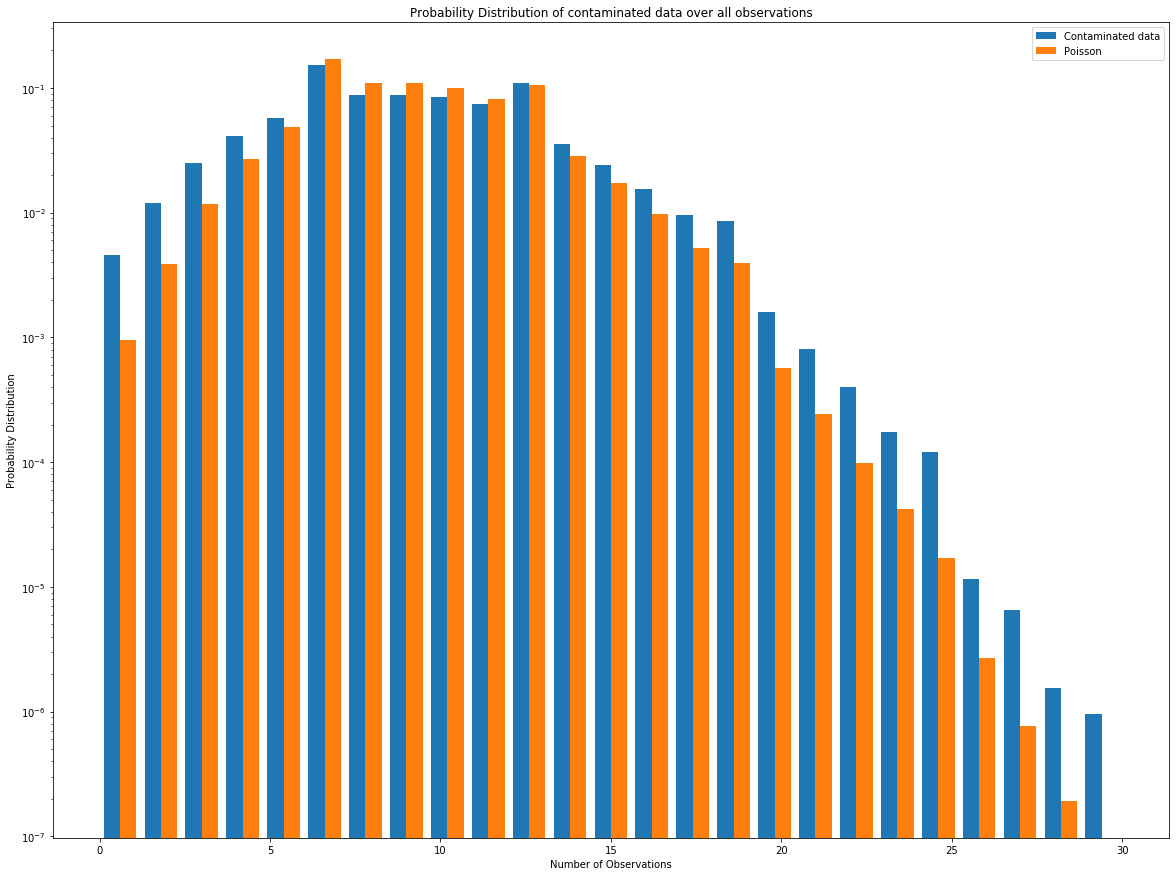

In [34]:
dist_3 = stats.poisson(np.mean(cont_raw))
vals_3 = dist_3.rvs(len(cont_raw))

_ = plt.hist([cont_raw, vals_3], density = True, bins=25)
plt.title('Probability Distribution of contaminated data over all observations')
plt.xlabel('Number of Observations')
plt.ylabel('Probability Distribution')
plt.legend(['Contaminated data', 'Poisson'])
plt.yscale('log')

The contaminated data also seems to folow a poisson distribution, but this one is centered at 9.08. This makes sense since it shows that the region is generally brighter than the others and is responsible for the spikes that we saw in our data earlier. We can also find the 5-sigma threshold for this.

In [35]:
threshold_2  = dist_3.ppf(stats.norm.cdf(5))
print('The 5-sigma threshold is ' + str(threshold_2) + ' observations.')

The 5-sigma threshold is 28.0 observations.


## Problem 2

In [238]:
hf = h5py.File('images.h5', 'r')

In [239]:
hf.keys()

<KeysViewHDF5 ['image1', 'imagestack']>

In [240]:
images = np.array(hf.get('imagestack'))

In [241]:
hf.close()

Here we have 10 images that have been through from a telescope and we will be looking for transient within these.

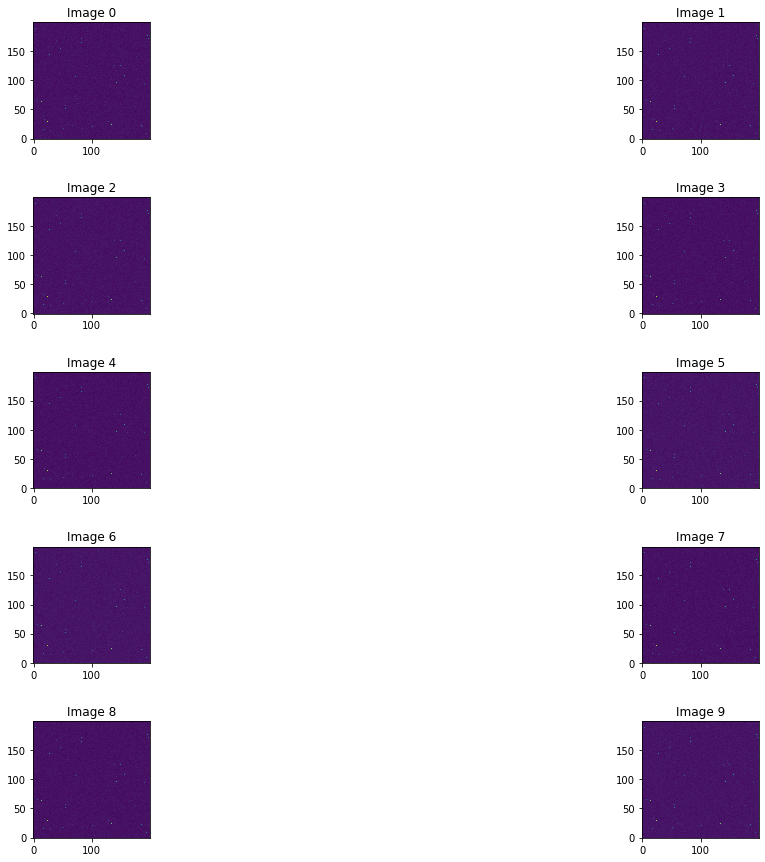

In [227]:
count = 0
fig, ax = plt.subplots(5,2)
for i in range(5):
    for j in range(2):
        ax[i][j].imshow(images[:,:,i+j], origin='left')
        ax[i][j].title.set_text('Image ' + str(count))
        count+=1
fig.subplots_adjust(hspace=0.5)

Instead of focusing on all our images, let's first look at just one. Let's say image number 4.

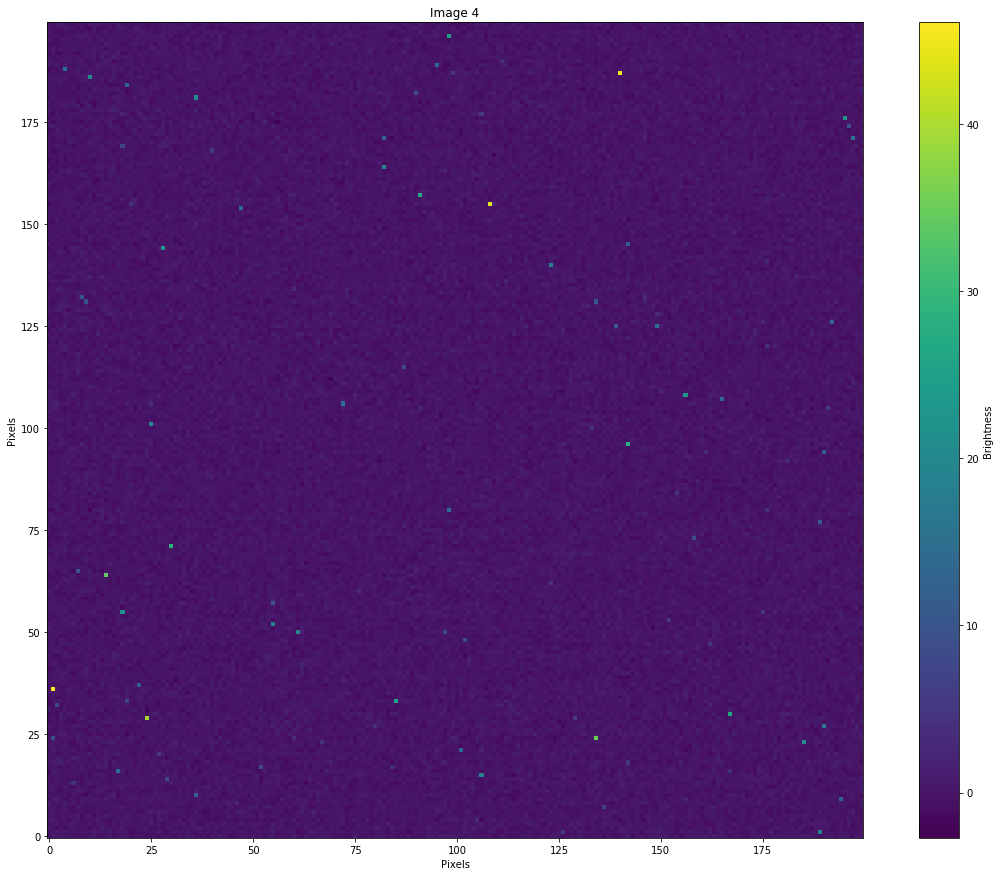

In [230]:
chosen_image = images[:, :, 3]
plt.imshow(chosen_image, origin='lower')
plt.title('Image 4')
plt.ylabel('Pixels')
plt.xlabel('Pixels')
cbar = plt.colorbar()
cbar.set_label('Brightness')

Now, for this image let us explore the data that builds it.

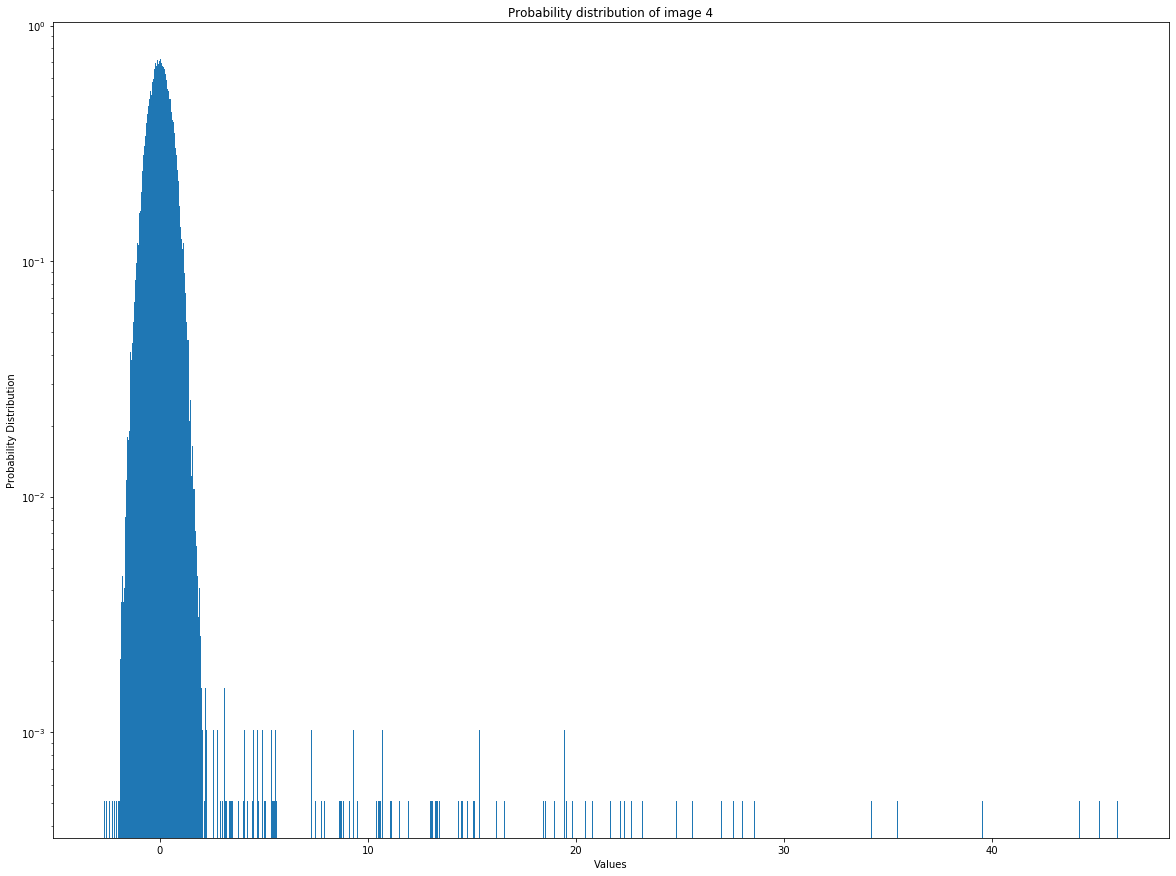

In [232]:
chosen_data = chosen_image.flatten()
_ = plt.hist(chosen_data, bins = 1000, density = True)
plt.title('Probability distribution of image 4')
plt.ylabel('Probability Distribution')
plt.xlabel('Values')
plt.yscale('log')

Looking at the distribution for this image, we can tell that it resembles a gaussian distribution centered at 0. We can also see that there seems to be some contamination based on the small spikes all the way to the end of the plot. The data also seems to be spatially consistent as it does not diverge from the initial blob. Finally, the data is certainly not time dependent since all the data contained in an image is taken at one instant. Now let's see what happens if we look at all the images.

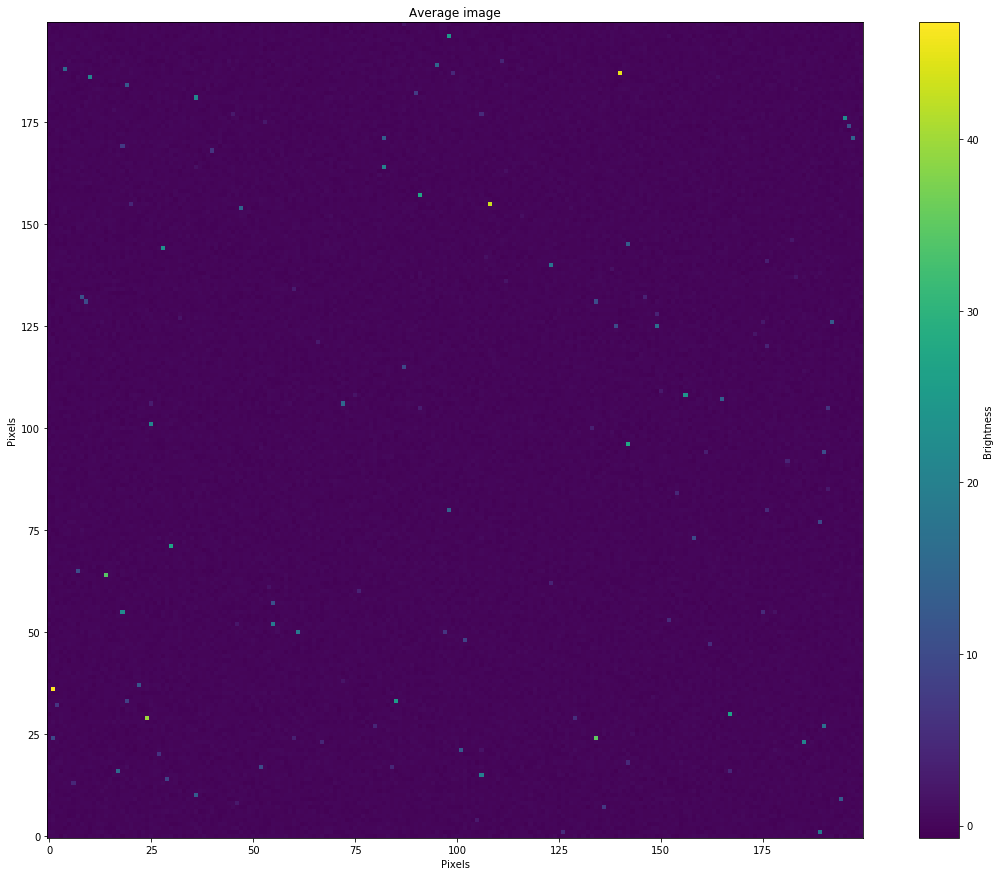

In [233]:
total = images[:,:,0]
for i in range(9):
    total = total + images[:,:,i+1]
avg = total / 10
plt.imshow(avg, origin='lower')
plt.title('Average image')
plt.ylabel('Pixels')
plt.xlabel('Pixels')
cbar = plt.colorbar()
cbar.set_label('Brightness')

Mean is 0.0004527966511028018
Standard deviation is 0.18040050731291812


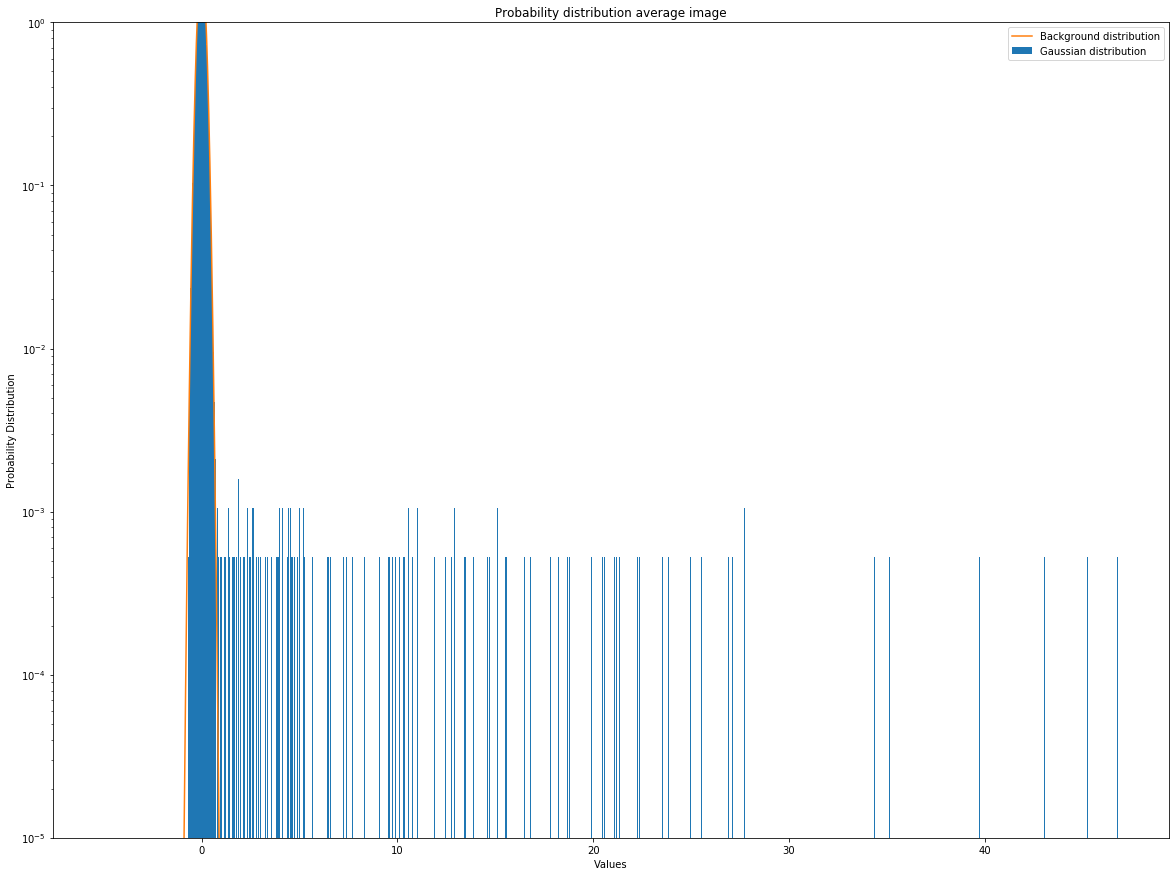

In [234]:
avg_data = avg.flatten()
temp = avg_data[avg_data < 2]

mu = np.mean(temp)
sd = np.std(temp)
x_v = np.linspace(-5,5,1000)
y_v = stats.norm(mu, sd).pdf(x_v)

_ = plt.hist(avg_data, bins = 1000, density = True)
plt.plot(x_v, y_v)
plt.title('Probability distribution average image')
plt.ylabel('Probability Distribution')
plt.xlabel('Values')
plt.yscale('log')
plt.ylim(1e-5, 1)
plt.legend(['Background distribution', 'Gaussian distribution'])
print('Mean is ' + str(mu))
print('Standard deviation is ' + str(sd))

Here we can see that after averaging all the images the distribution is still gaussian centered around 0 with a standard deviation of 0.18. 

Now that we know our background distribution, we can tackle the task of finding the transient signal that should only appear in one image. In order to do we need to focus on the signals that are of significance. In other words, we need to focus on bright signals that are 5-sigma or more to the right of the mean. Then we can go over all the images and check for data within each image to see if there exists any image that contains the transient stars.

In order to determine which image contains the transient signal, we loop over all the images and check each value and see if it is of significance or not. If it is then we assign it to a non-zero value and if it is not we assign it to a nan object which is essentially the same as making it zero. Then we find the aimage with the least nan objects.

In [265]:
cutoff = mu + 5 * sd

temp_images = np.copy(images)
res = np.zeros(10)

for i in range(10):
    temp_images[:,:,i][np.where(temp_images[:,:,i] < cutoff)] = np.nan
    temp_images[:,:,i][~np.isnan(temp_images[:,:,i])] = 1
    res[i] = np.count_nonzero(~np.isnan(temp_images[:,:,i]))
    
print('The image with the maximum number of significant values is ' + str(np.argmax(res) + 1))

The image with the maximum number of significant values is 3


Now that we know which image has the maximum number of significant values, we can conclude that the transient event takes place in the third image

In [266]:
final_image = temp_images[:,:,0]
for i in range(9):
    final_image = final_image + temp_images[:,:,i+1]

final_image[np.where(final_image[~np.isnan(final_image)] > 1)]= np.nan

Text(0, 0.5, 'Pixels')

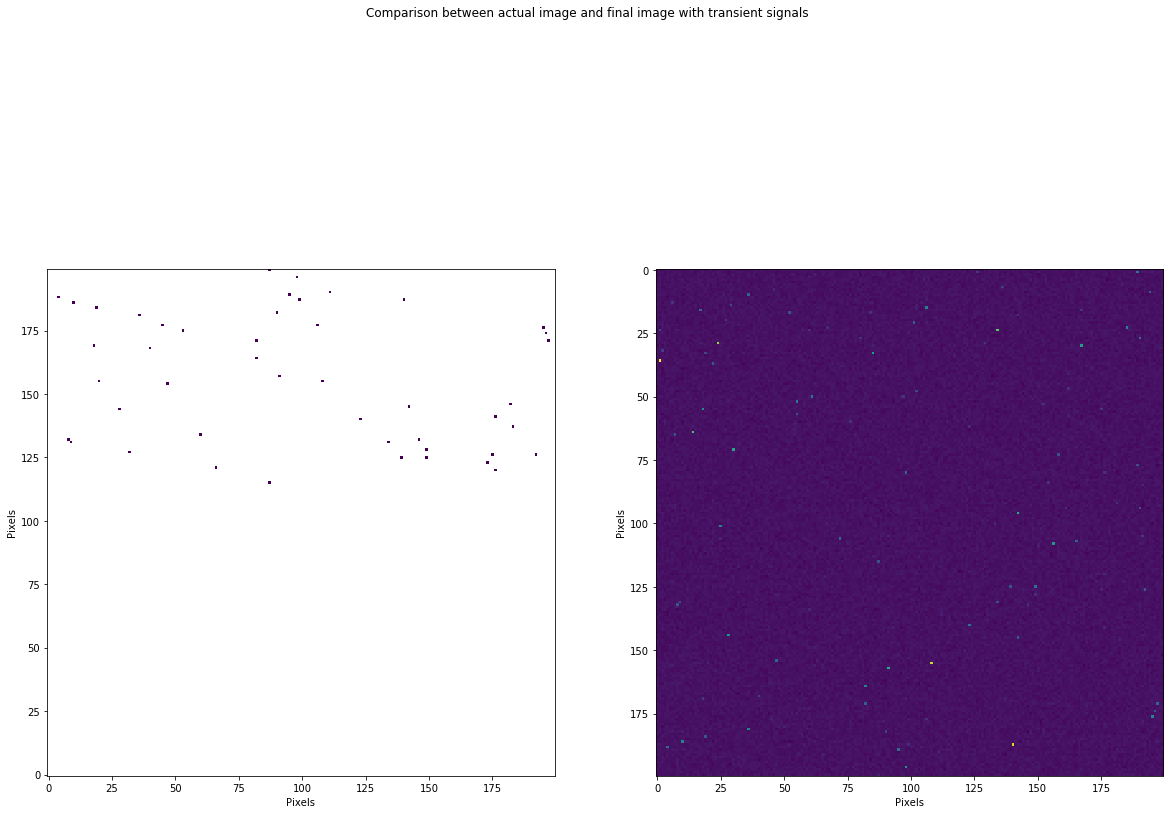

In [290]:
fig_2, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(final_image, origin = 'lower')
ax1.set_xlabel('Pixels')
ax1.set_ylabel('Pixels')
ax2.imshow(images[:,:,2])
fig_2.suptitle('Comparison between actual image and final image with transient signals')
plt.xlabel('Pixels')
plt.ylabel('Pixels')

While my partner and I were using the same data, our objectives were different. For me I had to find the signals that were brightest but only existed in one image whereas my partner needs to find the faintest stars over all the images. In doing so we are using different pdfs since mine is based on differences while his would be based on averages and sums. 